# 4.0 Modeling 

Contents

4.1 [Introduction](#4.1)

  * [4.1.1 Problem Recap](#4.1.1)
  * [4.1.2 Notebook Goals](#4.1.2)
 
4.2 [Load the data](#4.2)

  * [4.2.1 Imports](#4.2.1)
  * [4.2.2 Load the data](#4.2.2)

4.3 [Examine Class Split](#4.3)

4.4 [Pre-processing](#4.4)

  * [4.4.1 Set Random Seed for Reproducability](#4.4.1)
  * [4.4.2 Train/test Split](#4.4.2)
  * [4.4.4 Examine Class Split for Train/Test Data](#4.4.4)
  

4.5 [Setting Up Pipelines](#4.5)
  * 4.5.1 [Previous Best Model: Logistic Regression with Count Vectorization](#4.5.1)
<br/><br/>
    * [4.5.1.1 Training and Fitting the Model](#4.5.1.1)
    * [4.5.1.2 Evaluating the Model](#4.5.1.2)
<br/><br/>
 

## 4.1 Introduction <a name="4.1"></a>

### 4.1.1 Problem Recap <a name="4.1.1"><a/>

Using customer text data about amazon products, we will build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

Our goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data. The metric we will be primarily interested in will be Recall on the positive class. This is the proportion of the positive class (negative reviews coded as "1" in the data) we correctly predict.

### 4.1.2 Notebook Goals <a name="4.1.2"></a>

1. In our previous notebook our best results came from Term-Frequency Inverse-Document Frequency vectorization and a Logistic Regression Model.

2. We had slightly worse results from a Naive Bayes and Random Forest model. The Naive Bayes model incorrectly predicted a higher proportion of the negative class and the Random Forest model appeared to strongly overfit the training data with a very poor Recall on the test set.

3. Try over-sampling the minority class that we are trying to predict (encoded as "1"s) and/or under-sampling the majority class.

4. Test some other models such as gradient boosted trees (LightGBM/XGBoost) 

5. Examine how well our models will generalize with K-fold cross validation.

6. Tune hyper-parameters with grid-search or bayesian search optimization.

## 4.2 Load the data <a name="4.2"><a/>

### 4.2.1 Imports <a name="4.2.1"><a/>

In [1]:
from random import seed

#reading/processing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq


#splitting the dataset
from sklearn.model_selection import train_test_split

#scaling/vectorization
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec, FastText

# models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


#metrics
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, RocCurveDisplay

/home/paul/anaconda3/envs/pyspark/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 4.2.2 Load the data <a name="4.2.2"><a/>

In [2]:
data = pq.read_table("../data/edited/fashion.parquet")
fashion = data.to_pandas()

In [3]:
fashion.head()

,review,neg_sentiment,stars,review_length
0,exactly needed,0,5,4
1,agree review opening small bent hook expensiv...,1,2,49
2,love going order pack work including losing ea...,0,4,50
3,tiny opening,1,2,4
4,okay,1,3,1


In [4]:
fashion.describe()

,neg_sentiment,stars,review_length
count,873352.000000,873352.000000,873352.000000
mean,0.304939,3.904786,29.131591
std,0.460382,1.419361,39.372047
min,0.000000,1.000000,1.000000
25%,0.000000,3.000000,7.000000
50%,0.000000,5.000000,17.000000
75%,1.000000,5.000000,36.000000
max,1.000000,5.000000,2196.000000


In [5]:
fashion.shape

(873352, 4)

## 4.3 Reproducing the Train-Test Split <a name="4.3"><a/>

### 4.3.1 Use Identical Random Seed from Previous Notebook<a name="4.3.1"><a/>

In [6]:
seed(42)

### 4.3.2 Train/Test Split <a name="4.3.2"><a/>

In [7]:
#split into train and test with a 90% / 10% ratio

X_train, X_test, y_train, y_test = train_test_split(fashion["review"].values, fashion["neg_sentiment"], test_size = .1)

### 4.3.3 Check Class Split for Train/Test Data <a name="4.3.3"><a/>

In [8]:
def plot_sentiment_split(df_col:pd.Series):
    """
    Plot the split between our positive and negative classes
    """
    df_col.value_counts().plot(kind="pie")
    plt.legend(labels=("Positive Reviews","Negative Reviews"))
    plt.title("Review Sentiment Split")
    plt.show()

    positive, negative = df_col.value_counts(normalize=True).values

    pos_perc = round(positive * 100, 2)
    neg_perc = round(negative * 100, 2)
    print(f"Positive reviews: {pos_perc}%\n", f"Negative reviews: {neg_perc}%")

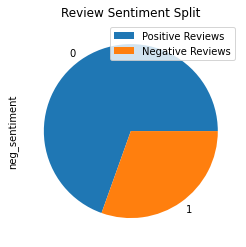

Positive reviews: 69.54%
 Negative reviews: 30.46%


In [9]:
plot_sentiment_split(y_train)

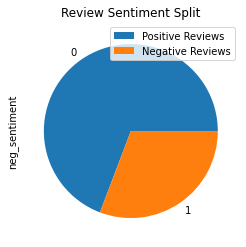

Positive reviews: 69.22%
 Negative reviews: 30.78%


In [10]:
plot_sentiment_split(y_test)

#### Both the training and test data after splitting is very representative of the split of the entire dataset (roughly .1 percent difference).

In [11]:
#convert to 1d arrays for modeling
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

### XGBoost Classifier with TFIDF

In [51]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_df=0.95)

#fit the vectorizer on the training data
tfidf.fit(X_train)

#transform both the training and test data
X_train_vec = tfidf.transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [52]:
xg = xgb.XGBClassifier(n_estimators=500)
xg.fit(X_train_vec, y_train)

/home/paul/anaconda3/envs/pyspark/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
train_preds = xg.predict(X_train_vec)

In [54]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93    546575
           1       0.88      0.80      0.84    239441

    accuracy                           0.91    786016
   macro avg       0.90      0.88      0.89    786016
weighted avg       0.90      0.91      0.90    786016



In [55]:
test_preds = xg.predict(X_test_vec)

In [56]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     60458
           1       0.85      0.78      0.81     26878

    accuracy                           0.89     87336
   macro avg       0.88      0.86      0.87     87336
weighted avg       0.89      0.89      0.89     87336



In [ ]:
from pycaret import *